In [78]:
%matplotlib inline

import numpy as np
from scipy.integrate import odeint
import emcee
import corner

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update({'font.size': 18})

In [88]:
def genetic_model(y, t, alpha1, alpha2, gamma, beta, eta, IPTG, K):
    # u = y[0], v = y[1]
    u, v = y
    w = u/(1.0 + np.power(IPTG/K,eta))
    
    return [alpha1/(1.0 + np.power(v,beta)) - u, alpha2/(1.0 + np.power(w,gamma)) - v]

In [66]:
# Initial conditions
t = np.linspace(0.0, 10.0, 100)

alpha1 = 143.0
alpha2 = 15.95
gamma = 2.70
beta = 0.96
eta = 2.34
K = 2.7e-5
IPTG = 1.0e-6

# Initial guess
y0 = [1.0e-2, 1.0e-2]

In [89]:
sol = odeint(genetic_model, y0, t, args=(alpha1, alpha2, gamma, beta, eta, IPTG, K))

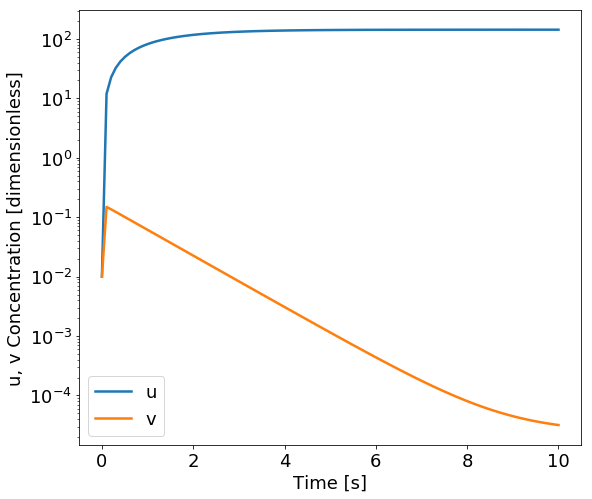

In [68]:
fig, ax = plt.subplots(figsize=(9,8))

ax.plot(t, sol[:,0], lw=2.5, label="u")
ax.plot(t, sol[:,1], lw=2.5, label="v")

# Format
ax.legend()
ax.set_yscale("log")
ax.set_ylabel("u, v Concentration [dimensionless]")
ax.set_xlabel("Time [s]")

In [86]:
obs = float(sol[-1,1] + np.sqrt(5.0e-4)*np.random.randn(1))
print(obs)

0.003937224264822326


In [83]:
sol[-1,1]

3.1826343015096331e-05

In [82]:
np.sqrt(5.0e-4)

0.022360679774997897

In [81]:
def genetic_lnprior(x):
    """
    Uniform log prior for the genetic switch likelihood following Wang & Li (2017)
    where the prior pi(x) is a uniform distribution for each parameter.

    Parameters
    ----------
    x : array

    Returns
    -------
    l : float
        log prior
    """

    x = np.array(x)
    if x.ndim > 1:
        alpha1 = x[:,0]
        alpha2 = x[:,1]
        gamma = x[:,2]
        beta = x[:,3]
        eta = x[:,4]
        K = x[:,5]
    else:
        alpha1, alpha2, gamma, beta, eta, K = x
    
    # All flat priors from Wang & Li (2017)
    if np.any(alpha1 < 120.0) or np.any(alpha1 > 200.0):
        return -np.inf
    elif np.any(alpha2 < 15.0) or np.any(alpha2 > 16.0):
        return -np.inf
    elif np.any(gamma < 2.1) or np.any(gamma > 2.9):
        return -np.inf
    elif np.any(beta < 0.85) or np.any(beta > 1.15):
        return -np.inf
    elif np.any(eta < 1.3) or np.any(eta > 2.7):
        return -np.inf
    elif np.any(K < 2.3e-5) or np.any(K > 3.7e-5):
        return -np.inf
    else:
        return 0.0
# end function

In [106]:
def genetic_sample(n):
    """
    Sample N points from the prior pi(x) is a uniform distribution over
    ranges given in Wang & Li (2017) for the genetic toggle example.

    Parameters
    ----------
    n : int
        Number of samples

    Returns
    -------
    sample : floats
        n x 6 array of floats samples from the prior
    """
    
    alpha1 = np.random.uniform(low=120.0, high=200.0, size=(n,1))
    alpha2 = np.random.uniform(low=15.0, high=16.0, size=(n,1))
    gamma = np.random.uniform(low=2.1, high=2.9, size=(n,1))
    beta = np.random.uniform(low=0.85, high=1.15, size=(n,1))
    eta = np.random.uniform(low=1.3, high=2.7, size=(n,1))
    K = np.random.uniform(low=2.3, high=3.7, size=(n,1))*1.0e-5

    return np.hstack([alpha1, alpha2, gamma, beta, eta, K])
# end function

In [129]:
def genetic_lnlike(x):
    """
    Log-likelihood for the genetic switch likelihood following Wang & Li (2017).
    
    Valid for the following "true" forward model parameters:
    
    alpha1 = 143.0
    alpha2 = 15.95
    gamma = 2.70
    beta = 0.96
    eta = 2.34
    K = 2.7e-5
    IPTG = 1.0e-6
    
    observable: 3.1826343015096331e-05 (v concentration at t=10)
    noise level: 0.022360679774997897 (sqrt(5.0e-4))
    
    Parameters
    ----------
    x : array

    Returns
    -------
    l : float
        lnlike
    """
    
    # True value, error, true value + error (error sampled from N(0,err^2))
    obs = 3.183e-05
    err = 0.0224
    erred_obs = 0.00394
    IPTG = 1.0e-6
    
    # Unpack data
    x = np.array(x)
    if x.ndim > 1:
        alpha1 = x[:,0]
        alpha2 = x[:,1]
        gamma = x[:,2]
        beta = x[:,3]
        eta = x[:,4]
        K = x[:,5]
    else:
        alpha1, alpha2, gamma, beta, eta, K = x
        
    # Run forward model to get prediction (final value of v)
    t = np.linspace(0.0, 10.0, 100)
    y0 = [1.0e-2, 1.0e-2] # results not sensitive to initial conditions
    sol = odeint(genetic_model, y0, t, args=(alpha1, alpha2, gamma, beta, eta, IPTG, K))

    return -0.5*((erred_obs - sol[-1,1])**2 / err**2)
# end function

In [134]:
def lnprob(x):
    lp = print(genetic_lnprior(x))
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + genetic_lnlike(x)

In [135]:
ndim = 6          # Number of dimensions
nsteps = 1000     # Number of MCMC iterations
verbose = False   # Don't output lots of stuff

nwalk = 10 * ndim # Use 10 walkers per dimension

# Initial guess for walkers (random over prior)
p0 = [genetic_sample(1) for j in range(nwalk)]

In [136]:
sampler = emcee.EnsembleSampler(nwalk, ndim, lnprob)

In [137]:
for i, result in enumerate(sampler.sample(p0, iterations=nsteps)):
    if verbose:
        print("%d/%d" % (i+1, nsteps))
                
print("emcee finished!")

0.0
emcee: Exception while calling your likelihood function:
  params: [[  1.62328428e+02   1.50652178e+01   2.55684726e+00   1.05910875e+00
    1.30029374e+00   2.31265017e-05]]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/dflemin3/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-134-9372d8561f61>", line 4, in lnprob
    print(lp,genetic_lnlike(x))
NameError: name 'lp' is not defined


NameError: name 'lp' is not defined